[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zixiangloh/CU_DL_Final_Project_CNN/blob/main/demos/increasing_in_distribution_combinations_modified_with_mnist_clothing.ipynb)

# Overview


This demo shows the impact of increasing in-distribution combinations on out-of-distribution generalization. Specifically, we reproduce the results for the MNIST Rotation dataset on the `SHARED` architecture.

As shown below, this architecture enforces parameter sharing between the two tasks (category prediction and viewpoint prediction).

As described in the paper, our results show that increasing data diversity (i.e. in-distribution combinations) leads to a substantial increase in out-of-distribution performance eventhough total number of training images (dataset size) is held constant.

![Shared Architecture](../docs/images/Shared.png)

In [1]:
import os
def create_folder(path):
    if not os.path.isdir(path):
        os.mkdir(path)

If running on google colab, the below code does the following:
- clone repo
- set up necessary folders
- download MNIST Rotation Dataset at appropriate place
- unzip MNIST Rotation

#### If you're not running on colab, please follow download instructions to get the mnist_rotaiton dataset using:

```
cd utils
bash download_mnist_rotation.sh
```

#### If not using google colab, please proceed below only after downloading the dataset

In [2]:
if 'google.colab' in str(get_ipython()):
    print('Cloning code base to colab....')
    # We are going to point this to our own repo so that we can modify the code 
    !git clone https://github.com/zixiangloh/CU_DL_Final_Project_CNN
    !cd CU_DL_Final_Project_CNN/utils && bash download_mnist_rotation.sh
    !cd CU_DL_Final_Project_CNN/data/mnist_clothing && python gen_mnist_clothing_discrete_rotation_data.py
    CODE_ROOT = "CU_DL_Final_Project_CNN/"
else:
    CODE_ROOT = '..'
print(CODE_ROOT)

..


In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
import argparse
import pickle
import sys
main_path = os.path.join(CODE_ROOT, 'res') # This allows Windows style pathing
print(main_path)
print(os.path.isdir(main_path))
sys.path.append(main_path)
from models.models import get_model
from loader.loader import get_loader

..\res
True
D:\DL_Final_Project\CU_DL_Final_Project_CNN\demos
..\res\loader\loader.py
..\res\loader


In [4]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("Set1", 8, .75)
sns.despine()

<Figure size 432x288 with 0 Axes>

This demo trains networks with 1, 3, 6 and 9 in-distribution combinations of the MNIST-Rotation dataset, and plots performance on out-of-distribution combinations from the dataset.

To run on a different architecture, please change the `ARCH` variable below.

In [5]:
DATASET_NAMES = ['mnist_clothing_one_by_nine', 'mnist_clothing_three_by_nine',
                 'mnist_clothing_six_by_nine', 'mnist_clothing_nine_by_nine']
NUM_EPOCHS = 10
BATCH_SIZE = 200
ARCH = 'LATE_BRANCHING_COMBINED'

image_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


GPU = 1

In [6]:
NUM_CLASSES = (10,10,10,10)
loader_new = get_loader('multi_attribute_loader_file_list_mnist_rotation')  
# We'll use the same loader since the clothing dataset is similar

# file_list_root = '%s/dataset_lists/mnist_rotation_lists/'%CODE_ROOT
# att_path = '%s/dataset_lists/combined_attributes.p'%CODE_ROOT
file_list_root = os.path.join(CODE_ROOT, 'dataset_lists', 'mnist_clothing_lists') # use clothing dataset
att_path = os.path.join(CODE_ROOT, 'dataset_lists', 'combined_attributes.p')

In [7]:
with open(att_path, 'rb') as F:
    temp = pickle.load(F)
print(type(temp))

<class 'dict'>


In [8]:
shuffles = {'train':True,'val':True,'test':False}

In [9]:
data_dir = '%s/data'%CODE_ROOT # This we do not change 

In [10]:
all_dsets = {}
all_dset_loaders = {}
all_dset_sizes = {}

for DATASET_NAME in DATASET_NAMES:
    file_lists = {}
    dsets = {}
    dset_loaders = {}
    dset_sizes = {}
    for phase in ['train','val','test']:
        file_lists[phase] = os.path.join(file_list_root, "{}_list_{}.txt".format(phase, DATASET_NAME))
#         file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,DATASET_NAME)
        dsets[phase] = loader_new(file_lists[phase],att_path, image_transform, data_dir)
        dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=BATCH_SIZE, shuffle = shuffles[phase], num_workers=2,drop_last=True)
        dset_sizes[phase] = len(dsets[phase])
    all_dsets[DATASET_NAME] = dsets
    all_dset_loaders[DATASET_NAME] = dset_loaders
    all_dset_sizes[DATASET_NAME] = dset_sizes

In [11]:
multi_losses = [nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss()]

In [12]:
def weight_scheduler(epoch_num, task):
    if task == 'shared':
        return [0.0,1.0,0.0,1.0]
    elif task == 'viewpoint':
        return [0.0,1.0,0.0,0.0]
    elif task == 'category':
        return [0.0,0.0,0.0,1.0]

In [13]:
def train_epoch(dset_loaders, dset_sizes, model, task, optimizer):
    model.train()
    torch.set_grad_enabled(True)
    phase = 'train'
    
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())

        optimizer.zero_grad()
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]

        
        phase_epoch_loss += calculated_loss
        calculated_loss.backward()
        optimizer.step()
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Train loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]

    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    return model, epoch_loss, epoch_gm

In [14]:
def test_epoch(dset_loaders, dset_sizes, model, best_model, best_test_loss, best_test_gm, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'val'
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Test loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    if epoch_loss < best_test_loss:
        best_model = model
        best_test_loss = epoch_loss
        best_test_gm = epoch_gm
    
    return best_model, epoch_loss, epoch_gm, best_test_loss, best_test_gm

In [15]:
def unseen_test_epoch(dset_loaders, dset_sizes, model, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'test'

    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    return epoch_loss, epoch_gm

In [16]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

In [17]:
DATASET_NAMES

['mnist_clothing_one_by_nine',
 'mnist_clothing_three_by_nine',
 'mnist_clothing_six_by_nine',
 'mnist_clothing_nine_by_nine']

In [18]:
dataset_titles = {}
dataset_titles['mnist_clothing_one_by_nine'] = "10% combinations seen"
dataset_titles['mnist_clothing_three_by_nine'] = "30% combinations seen"
dataset_titles['mnist_clothing_six_by_nine'] = "60% combinations seen"
dataset_titles['mnist_clothing_nine_by_nine'] = "90% combinations seen"

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Task: viewpoint
---------
Epoch: 0, Task: category
---------
Epoch: 0, Task: shared
---------
Epoch: 1, Task: viewpoint
---------
Epoch: 1, Task: category
---------
Epoch: 1, Task: shared
---------
Epoch: 2, Task: viewpoint
---------
Epoch: 2, Task: category
---------
Epoch: 2, Task: shared
---------
Epoch: 3, Task: viewpoint
---------
Epoch: 3, Task: category
---------
Epoch: 3, Task: shared
---------
Epoch: 4, Task: viewpoint
---------
Epoch: 4, Task: category
---------
Epoch: 4, Task: shared
---------


C:\Users\zixiangloh\anaconda3\envs\geo_env_3p7\lib\site-packages\ipykernel_launcher.py:82: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


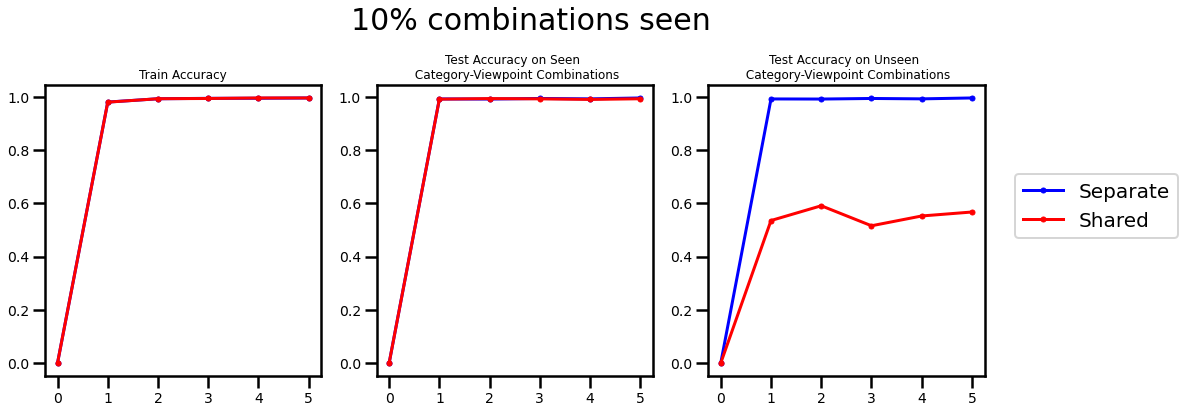

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Task: viewpoint
---------
Epoch: 0, Task: category
---------
Epoch: 0, Task: shared
---------
Epoch: 1, Task: viewpoint
---------
Epoch: 1, Task: category
---------
Epoch: 1, Task: shared
---------
Epoch: 2, Task: viewpoint
---------
Epoch: 2, Task: category
---------
Epoch: 2, Task: shared
---------
Epoch: 3, Task: viewpoint
---------
Epoch: 3, Task: category
---------
Epoch: 3, Task: shared
---------
Epoch: 4, Task: viewpoint
---------
Epoch: 4, Task: category
---------
Epoch: 4, Task: shared
---------


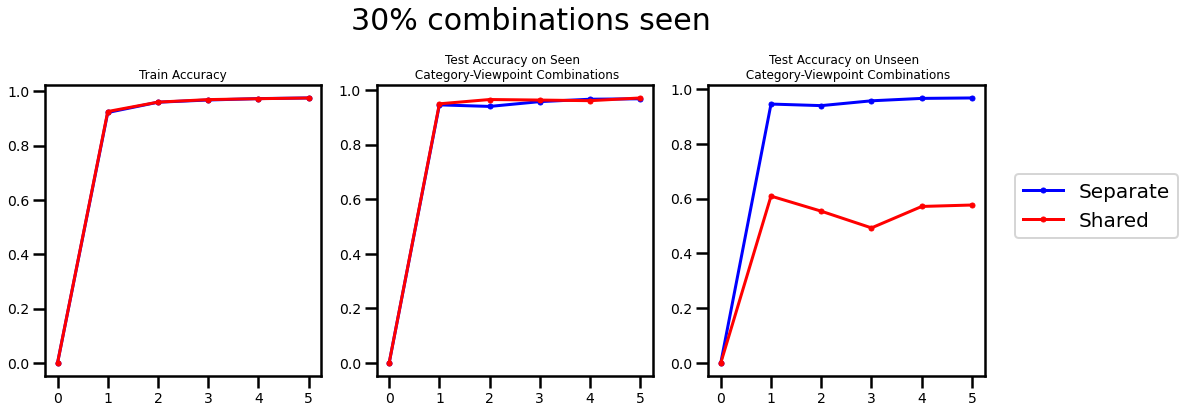

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Task: viewpoint
---------
Epoch: 0, Task: category
---------
Epoch: 0, Task: shared
---------
Epoch: 1, Task: viewpoint
---------
Epoch: 1, Task: category
---------
Epoch: 1, Task: shared
---------
Epoch: 2, Task: viewpoint
---------
Epoch: 2, Task: category
---------
Epoch: 2, Task: shared
---------
Epoch: 3, Task: viewpoint
---------
Epoch: 3, Task: category
---------
Epoch: 3, Task: shared
---------
Epoch: 4, Task: viewpoint
---------
Epoch: 4, Task: category
---------
Epoch: 4, Task: shared
---------


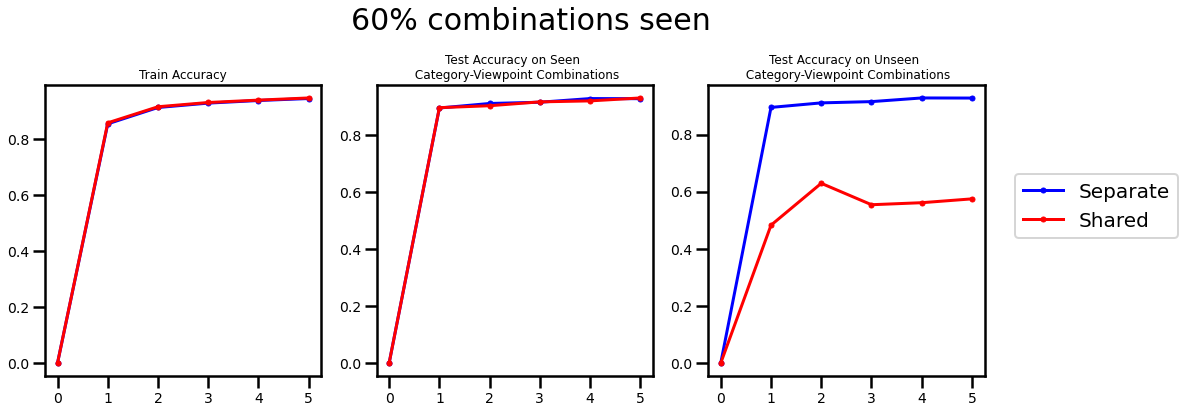

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Task: viewpoint
---------
Epoch: 0, Task: category
---------
Epoch: 0, Task: shared
---------
Epoch: 1, Task: viewpoint
---------
Epoch: 1, Task: category
---------
Epoch: 1, Task: shared
---------
Epoch: 2, Task: viewpoint
---------
Epoch: 2, Task: category
---------
Epoch: 2, Task: shared
---------
Epoch: 3, Task: viewpoint
---------
Epoch: 3, Task: category
---------
Epoch: 3, Task: shared
---------
Epoch: 4, Task: viewpoint
---------
Epoch: 4, Task: category
---------
Epoch: 4, Task: shared
---------


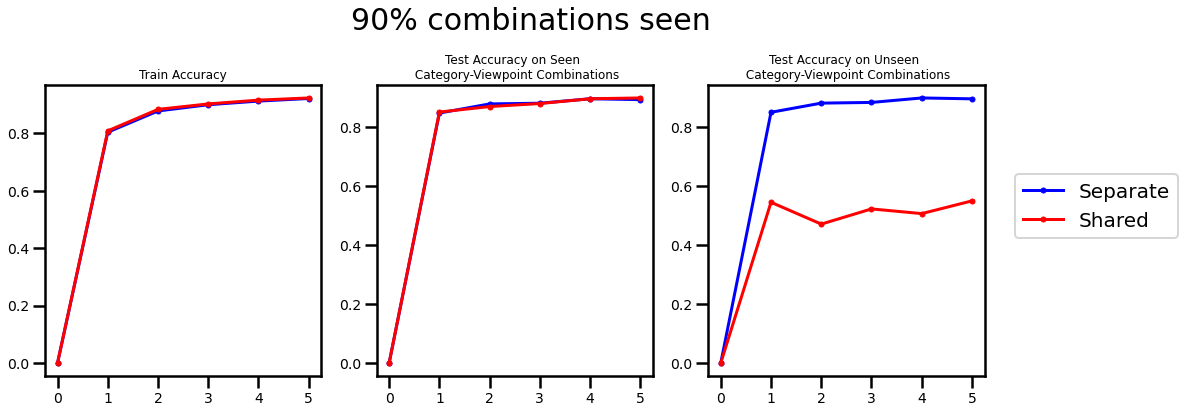

In [19]:
for DATASET_NAME in DATASET_NAMES:
    dsets = all_dsets[DATASET_NAME]
    dset_loaders = all_dset_loaders[DATASET_NAME]
    dset_sizes = all_dset_sizes[DATASET_NAME]
    
    models = {}

    models['shared']= get_model(ARCH,NUM_CLASSES)
    models['viewpoint']= get_model(ARCH,NUM_CLASSES)
    models['category']= get_model(ARCH,NUM_CLASSES)

    models['shared'].cuda();
    models['viewpoint'].cuda();
    models['category'].cuda();

    best_models = {}
    best_models['shared'] = models['shared']
    best_models['viewpoint'] = models['viewpoint']
    best_models['category'] = models['category']

    best_test_loss = 100
    best_test_gm = 0

    all_train_gms = {}
    all_train_gms['shared'] = [0]
    all_train_gms['separate'] = [0]

    all_test_gms = {}
    all_test_gms['shared'] = [0]
    all_test_gms['separate'] = [0]

    all_unseen_test_gms = {}
    all_unseen_test_gms['shared'] = [0]
    all_unseen_test_gms['separate'] = [0]

    optimizers = {}
    optimizers['shared'] = optim.Adam(models['shared'].parameters(), lr=0.001)
    optimizers['viewpoint'] = optim.Adam(models['viewpoint'].parameters(), lr=0.001)
    optimizers['category'] = optim.Adam(models['category'].parameters(), lr=0.001)
    for epoch in tqdm(range(5)):
        train_gm_separate = 1
        test_gm_separate = 1
        unseen_test_gm_separate = 1

        for TASK in ['viewpoint','category','shared']:
            print('Epoch: %s, Task: %s'%(epoch,TASK))
            print('---------')
            models[TASK], train_loss, train_gm = train_epoch(dset_loaders, dset_sizes, models[TASK], TASK, optimizers[TASK])
            best_models[TASK], test_loss, test_gm, best_test_loss, best_test_gm = test_epoch(dset_loaders, dset_sizes, models[TASK], best_models[TASK], best_test_loss, best_test_gm, TASK)
            unseen_test_loss, unseen_test_gm = unseen_test_epoch(dset_loaders, dset_sizes, models[TASK], TASK)

            if TASK != 'shared':
                train_gm_separate = train_gm_separate * train_gm
                test_gm_separate = test_gm_separate * test_gm
                unseen_test_gm_separate = unseen_test_gm_separate * test_gm

        all_train_gms['separate'].append(np.sqrt(train_gm_separate))
        all_test_gms['separate'].append(np.sqrt(test_gm_separate))
        all_unseen_test_gms['separate'].append(np.sqrt(unseen_test_gm_separate))
        all_train_gms['shared'].append(train_gm)
        all_test_gms['shared'].append(test_gm)
        all_unseen_test_gms['shared'].append(np.sqrt(unseen_test_gm))

    fig,ax = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle(dataset_titles[DATASET_NAME], fontsize = 30)
    l1 = ax[0].plot(all_train_gms['separate'], color = 'blue', marker = 'o', markersize=5)[0]
    l2 = ax[0].plot(all_train_gms['shared'], color = 'red', marker = 'o', markersize=5)[0]
    ax[0].set_title('Train Accuracy', fontsize=12)
    line_labels = ["Separate", "Shared"]

    ax[1].plot(all_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
    ax[1].plot(all_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
    ax[1].set_title('Test Accuracy on Seen \n Category-Viewpoint Combinations', fontsize=12)

    ax[2].plot(all_unseen_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
    ax[2].plot(all_unseen_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
    ax[2].set_title('Test Accuracy on Unseen \n Category-Viewpoint Combinations', fontsize=12)
    fig.legend([l1, l2],     # The line objects
            labels=line_labels,   # The labels for each line
            loc="center right",   # Position of legend
            borderaxespad=0.2,    # Small spacing around legend box
            prop={"size":20})
    plt.subplots_adjust(right=0.85, top =0.80)
    plt.show()